In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import sklearn.metrics
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical 

import tensorflow as tf
from keras.models import Model
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import Dense, Activation, Flatten
from keras.layers.convolutional import Convolution2D, Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback

Using TensorFlow backend.


In [2]:
conv1_filter = 8
conv2_filter = 16
conv3_filter = 32
conv4_filter = 64

In [3]:
x = np.load('./datasets/data_bestofcuts/x.npy')
y = np.load('./datasets/data_bestofcuts/y.npy')

In [4]:
xtrain, xval, ytrain, yval = train_test_split(x, y, test_size=0.10, random_state=42, stratify=y)

print xtrain.shape
print xval.shape

(813, 60, 41, 2)
(91, 60, 41, 2)


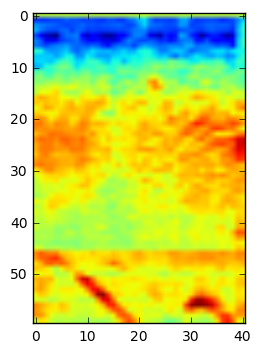

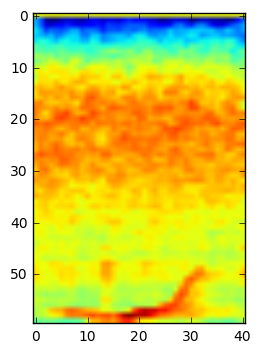

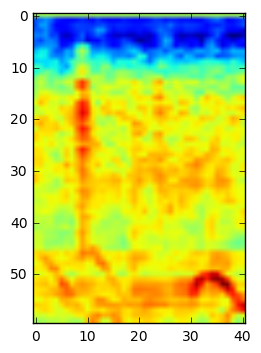

In [5]:
xtrain.shape
for i in range(3):
    plt.show(plt.imshow(xtrain[i,:,:,0]))
#     plt.show(plt.imshow(xtrain[i,:,:,1]))

In [6]:
STRIP_HEIGHT = xtrain.shape[1]
STRIP_WIDTH = xtrain.shape[2]
CHANNELS = xtrain.shape[3]
CLASSES = 4

In [7]:
class EvaluateValidation(Callback):      
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nValidation loss: {}, acc: {}\n'.format(loss, acc))

In [8]:
### Model ###                                                                                                                               
model = Sequential()                                                                                                                                                                      
k_init = 'he_normal'
bias_init = Constant(value=0.1)
ridge = 0.0002

model.add(Convolution2D(conv1_filter, kernel_size=(5, 3), strides=(1, 1),
                        padding='same', data_format="channels_last", activation=None, use_bias=True,
                        kernel_regularizer=l2(ridge),
                        kernel_initializer=k_init, bias_initializer=bias_init,
                        input_shape=(STRIP_HEIGHT, STRIP_WIDTH, CHANNELS)))                                                                                                   
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(conv2_filter, kernel_size=(10, 5), strides=(1, 1),
                        padding='same', data_format="channels_last", activation=None, use_bias=True,
                        kernel_regularizer=l2(ridge),
                        kernel_initializer=k_init, bias_initializer=bias_init))                                                                                                   
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (4, 2), strides=(2, 2), padding='valid'))

model.add(Convolution2D(conv3_filter, kernel_size=(14, 7), strides=(1, 1),
                        padding='same', data_format="channels_last", activation=None, use_bias=True,
                        kernel_regularizer=l2(ridge),
                        kernel_initializer=k_init, bias_initializer=bias_init))                                                                                                   
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(conv4_filter, kernel_size=(18, 9), strides=(1, 1),
                        padding='same', data_format="channels_last", activation=None, use_bias=True,
                        kernel_regularizer=l2(ridge),
                        kernel_initializer=k_init, bias_initializer=bias_init))                                                                                                   
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size = (4, 2), strides=2, padding='valid'))

model.add(Flatten())
model.add(Dense(512, kernel_initializer=k_init,kernel_regularizer=l2(ridge)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(256, kernel_initializer=k_init,kernel_regularizer=l2(ridge)))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dense(256, kernel_initializer=k_init,kernel_regularizer=l2(ridge)))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(CLASSES, kernel_initializer=k_init,kernel_regularizer=l2(ridge)))
# model.add(BatchNormalization())
model.add(Activation('softmax'))

Lr = 1e-3 
dcy = 2e-5                                                                                                                                                                                
m = 0.5
batch_sz = 25
epoch = 50
sgd = SGD(lr=Lr, momentum=m, decay=dcy,  nesterov=True)
# adam = Adam(lr=Lr, decay=dcy)

model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

model.summary()
print('learning rate: %f, decay: %f' %(Lr, dcy))

from keras.backend import get_session
get_session().run(tf.global_variables_initializer())
a = model.fit(xtrain, ytrain, batch_size = batch_sz, epochs= epoch, verbose = 2,
              callbacks=[EvaluateValidation((xval, yval))])

loss_and_metrics = model.evaluate(xval, yval, batch_size=batch_sz)

print "Loss and accuracy: ", loss_and_metrics

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 60, 41, 8)         248       
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 41, 8)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 60, 41, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 41, 16)        6416      
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 41, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 60, 41, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 20, 16)        0         
__________

In [9]:
y_pred = model.predict(xval)

In [10]:
i = 0
for layer in model.layers:
    print "{}: {}".format(i,layer)
    i += 1

0: <keras.layers.convolutional.Conv2D object at 0x2aab1a178a10>
1: <keras.layers.normalization.BatchNormalization object at 0x2aab1a125c10>
2: <keras.layers.core.Activation object at 0x2aab1a125ed0>
3: <keras.layers.convolutional.Conv2D object at 0x2aab1a178e50>
4: <keras.layers.normalization.BatchNormalization object at 0x2aab1a125310>
5: <keras.layers.core.Activation object at 0x2aab1a28fc10>
6: <keras.layers.pooling.MaxPooling2D object at 0x2aab1545a610>
7: <keras.layers.convolutional.Conv2D object at 0x2aab1a2bdf50>
8: <keras.layers.normalization.BatchNormalization object at 0x2aab1a2bd950>
9: <keras.layers.core.Activation object at 0x2aab1a0c83d0>
10: <keras.layers.convolutional.Conv2D object at 0x2aab19c6df90>
11: <keras.layers.normalization.BatchNormalization object at 0x2aab1a2bde90>
12: <keras.layers.core.Activation object at 0x2aab19c63ed0>
13: <keras.layers.pooling.MaxPooling2D object at 0x2aab15521e10>
14: <keras.layers.core.Flatten object at 0x2aab19c63310>
15: <keras.laye

In [15]:
def draw_weight(layer):
    filter_weights = np.array(model.layers[layer].get_weights())[0]
    num_filters = filter_weights.shape[3]
    channels = filter_weights.shape[2]
    for i in range(2):
        for j in range(2):
            plt.show(plt.imshow(filter_weights[:,:,j,i], interpolation='bilinear'))

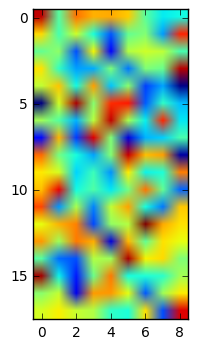

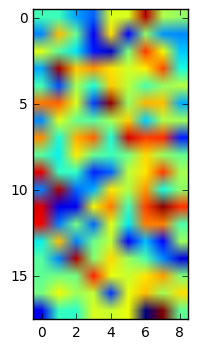

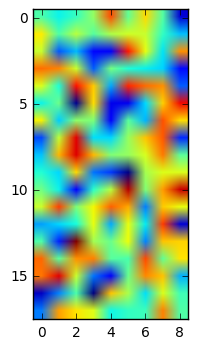

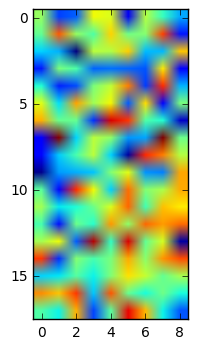

In [16]:
draw_weight(10)